In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
google_df = pd.read_csv('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/googl.us.txt')
print(google_df.head())

         Date    Open   High     Low   Close    Volume  OpenInt
0  2004-08-19  50.000  52.03  47.980  50.170  44703800        0
1  2004-08-20  50.505  54.54  50.250  54.155  22857200        0
2  2004-08-23  55.375  56.74  54.525  54.700  18274400        0
3  2004-08-24  55.620  55.80  51.785  52.435  15262600        0
4  2004-08-25  52.480  54.00  51.940  53.000   9197800        0


In [4]:
google_close_df = google_df['Close']
print(google_close_df.isna().sum())

0


<Axes: >

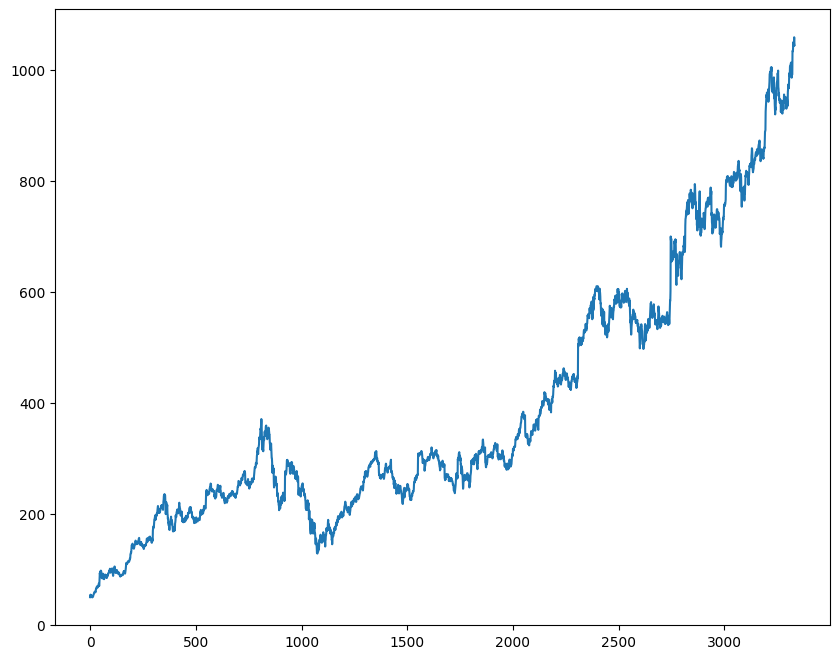

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
google_close_df.plot(ax=ax)

In [6]:
TEST_SIZE=0.15
train, test = train_test_split(google_close_df.values, test_size=TEST_SIZE, shuffle=False)
print('size: train {}, test {}'.format(train.shape, test.shape))

size: train (2833,), test (500,)


In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = np.squeeze(scaler.fit_transform(train.reshape(-1, 1)))
test_scaled = np.squeeze(scaler.transform(test.reshape(-1, 1)))
print('size: train {}, test {}'.format(train_scaled.shape, test_scaled.shape))

size: train (2833,), test (500,)


In [8]:
def split_sequence(sequence, n_step_in, n_step_out=1):
    X, y = list(), list()
    for i in range(len(sequence) - n_step_in - n_step_out):
        X.append(sequence[i:i + n_step_in])
        y.append(sequence[i + n_step_in: i + n_step_in + n_step_out])
        
    # warpping list of ndarry by ndarry may speed up the creation of tensors. It's instructed by a warning.
    return torch.tensor(np.array(X), dtype=torch.float), torch.tensor(np.array(y), dtype=torch.float)

In [9]:
N_STEP_IN=90
X_train, y_train = split_sequence(train_scaled, N_STEP_IN)
print(X_train[1000:1002], y_train[1000:1002])
print('size: train {}, test {}'.format(X_train.shape, y_train.shape))

tensor([[-0.4478, -0.4396, -0.4371, -0.4407, -0.4331, -0.4266, -0.4431, -0.4540,
         -0.4617, -0.4596, -0.4539, -0.4645, -0.4769, -0.4847, -0.4774, -0.4921,
         -0.4894, -0.4905, -0.5103, -0.5187, -0.5527, -0.5545, -0.5608, -0.5334,
         -0.5279, -0.5332, -0.5206, -0.5603, -0.5259, -0.5118, -0.5384, -0.5396,
         -0.5315, -0.5252, -0.5372, -0.6071, -0.5799, -0.5642, -0.5939, -0.5989,
         -0.6208, -0.6561, -0.6671, -0.6799, -0.6756, -0.6071, -0.6327, -0.6656,
         -0.6463, -0.6190, -0.6095, -0.6326, -0.6425, -0.6472, -0.6655, -0.6792,
         -0.6243, -0.6393, -0.6369, -0.6374, -0.6554, -0.6268, -0.6613, -0.6767,
         -0.6769, -0.6941, -0.7044, -0.7330, -0.7035, -0.7064, -0.7202, -0.7240,
         -0.7481, -0.7769, -0.7729, -0.7799, -0.7455, -0.7315, -0.7302, -0.7679,
         -0.7552, -0.7491, -0.7563, -0.7428, -0.7174, -0.7120, -0.7081, -0.7201,
         -0.6984, -0.7055],
        [-0.4396, -0.4371, -0.4407, -0.4331, -0.4266, -0.4431, -0.4540, -0.4617,


In [10]:
X_test, y_test = split_sequence(test_scaled, N_STEP_IN)
print('size: train {}, test {}'.format(X_test.shape, y_test.shape))

size: train torch.Size([409, 90]), test torch.Size([409, 1])


In [11]:
X_train = X_train.reshape(-1, N_STEP_IN, 1)
X_test = X_test.reshape(-1, N_STEP_IN, 1)
print(X_train.shape, X_test.shape)

torch.Size([2742, 90, 1]) torch.Size([409, 90, 1])


# build a LSTM model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
class LSTM(torch.nn.Module):
    def __init__(self, num_features, hidden_units, num_layers):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            num_layers=num_layers,
            batch_first=True
        )
        self.output = torch.nn.Linear(
            in_features=hidden_units,
            out_features=1  # we only forecast one variable
        )
        
    def forward(self, X):
        X, _ = self.lstm(X)
        '''
            In this case, the shape of X, output of the lstm, would be [batch_size, 90, 1]. For one of ninety, the lstm gave
            a result. However, only the last one was what we cared.
        '''
        X = X[:, -1, :]
        X = self.output(X)
        return X
    
model = LSTM(1, 32, 1)

model.to(device)

LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [14]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    
    loss_arr = list()
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(torch.squeeze(y_batch), torch.squeeze(y_pred))
        loss_arr.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return np.mean(loss_arr)
    
def evaluation(model, dataloader, optimizer, loss_fn, get_prediction=True):
    model.eval()
    
    loss_arr = list()
    pred_arr = list()
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            if get_prediction:
                pred_arr.extend(y_pred.cpu().numpy())
            loss = loss_fn(torch.squeeze(y_batch), torch.squeeze(y_pred))
            loss_arr.append(loss.item())
            
    return np.array(pred_arr), np.mean(loss_arr)
        
def trainer(model, epochs, trainloader, testloader, optimizer, loss_fn, log_step):
    if log_step > epochs:
        raise Exception('log step cannot be smaller than epochs')
            
    result = {
        'epoch': list(),
        'train loss': list(),
        'test loss': list()
    }
    
    for epoch in tqdm(range(epochs)):
        
        train_loss = train(model, trainloader, optimizer, loss_fn)
        
        if epoch % log_step != 0:
            _, test_loss = evaluation(model, testloader, optimizer, loss_fn, get_prediction=False)
            result['epoch'].append(epoch)
            result['train loss'].append(train_loss)
            result['test loss'].append(test_loss)
            
    return result

N_EPOCHS = 50
BATCH_SIZE=32

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=False, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=False, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
LOG_STEP = 20
res = trainer(model, N_EPOCHS, trainloader, testloader, optimizer, loss_fn, LOG_STEP)

100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


# results

<Axes: xlabel='epoch'>

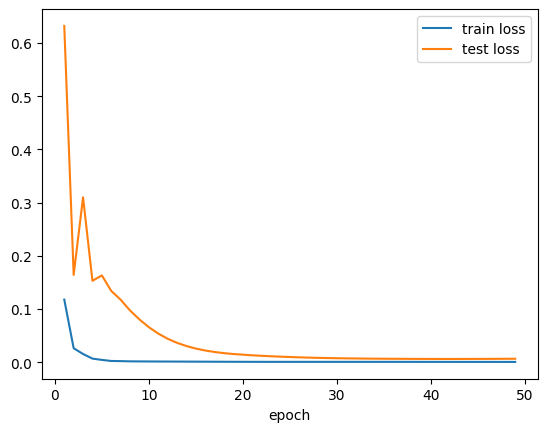

In [15]:
res_df = pd.DataFrame(res).set_index('epoch')
res_df.plot()

0.0067244407479078155


<Axes: >

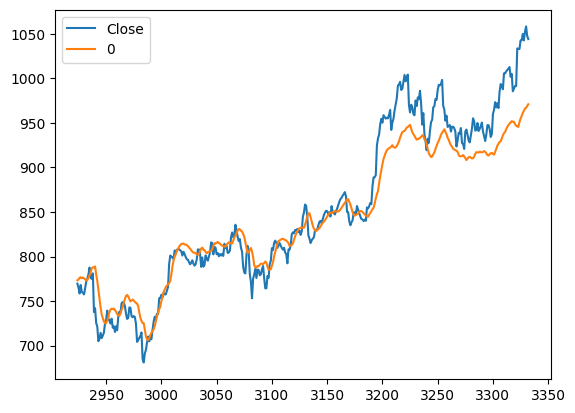

In [16]:
test_df = google_close_df.iloc[-len(y_test):].copy()

pred, avg_eval_loss = evaluation(model, testloader, optimizer, loss_fn)
print(avg_eval_loss)
test_df = pd.concat([test_df, pd.DataFrame(scaler.inverse_transform(pred), index=test_df.index)], axis=1)
test_df.plot()

# shuffle test

100%|██████████| 50/50 [00:10<00:00,  4.82it/s]

0.0018242287803262186


<Axes: >

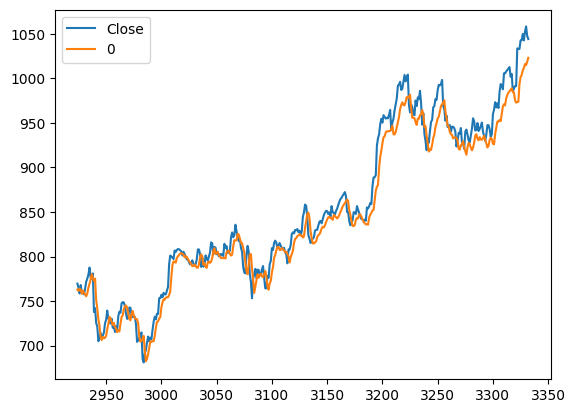

In [17]:
model2 = LSTM(1, 32, 1)

model2.to(device)

optimizer2 = torch.optim.Adam(model2.parameters())

res2 = trainer(model2,
               N_EPOCHS,
               torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE), 
               torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=True, batch_size=BATCH_SIZE), 
               optimizer2, 
               loss_fn, 
               LOG_STEP)


test_df = google_close_df.iloc[-len(y_test):].copy()

pred, avg_eval_loss = evaluation(model2,
                                 torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=False, batch_size=BATCH_SIZE),
                                 optimizer2, 
                                 loss_fn)
print(avg_eval_loss)
test_df = pd.concat([test_df, pd.DataFrame(scaler.inverse_transform(pred), index=test_df.index)], axis=1)
test_df.plot()